In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pandas.io.formats.style import Styler
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn import model_selection
from sklearn import metrics

In [48]:
def fix_columns(df): 
    """Removes (in millions) and (approx).1 from names of columns."""
    df.columns = df.columns.str.replace('(in millions)', '', regex=False)
    df.columns = df.columns.str.replace(' home(approx).1', '_home', regex=False)
    return df

PATH_ORIGIN = 'input/media-campaign-cost-prediction/train_dataset.csv'
PATH_TRAIN = 'input/playground-series-s3e11/train.csv'
PATH_TEST = 'input/playground-series-s3e11/test.csv'
PATH_SUB = 'input/playground-series-s3e11/sample_submission.csv'

origin = fix_columns(pd.read_csv(PATH_ORIGIN))
train = fix_columns(pd.read_csv(PATH_TRAIN).drop(columns='id'))
test = fix_columns(pd.read_csv(PATH_TEST).drop(columns='id'))

In [49]:
print(f'[INFO] Shapes:'
      f'\n[+] origin ->  {origin.shape}'
      f'\n[+] train  -> {train.shape}'
      f'\n[+] test   ->  {test.shape}\n')

print(f'[INFO] Any missing values:'
      f'\n[+] origin -> {origin.isna().any().any()}'
      f'\n[+] train  -> {train.isna().any().any()}'
      f'\n[+] test   -> {test.isna().any().any()}')

[INFO] Shapes:
[+] origin ->  (51363, 16)
[+] train  -> (360336, 16)
[+] test   ->  (240224, 15)

[INFO] Any missing values:
[+] origin -> False
[+] train  -> False
[+] test   -> False


In [50]:
def magnify(is_test: bool = False):
        base_color = '#FF5C19'
        if is_test:
            highlight_target_row = []
        else:
            highlight_target_row = [dict(selector='tr:last-child',
                                         props=[('background-color', f'{base_color}'+'20')])]
            
        return [dict(selector="th",
                     props=[("font-size", "11pt"),
                            ('background-color', f'{base_color}'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '0.1px solid white'),
                            ('border-left', '0.1px solid white'),
                            ('text-align', 'right')]),

                dict(selector='th.blank.level0', 
                    props=[('font-weight', 'bold'),
                           ('border-left', '1.7px solid white'),
                           ('background-color', 'white')]),

                dict(selector="td",
                     props=[('padding', "0.5em 1em"),
                            ('text-align', 'right')]),

                dict(selector="th:hover",
                     props=[("font-size", "14pt")]),

                dict(selector="tr:hover td:hover",
                     props=[('max-width', '250px'),
                            ('font-size', '14pt'),
                            ('color', f'{base_color}'),
                            ('font-weight', 'bold'),
                            ('background-color', 'white'),
                            ('border', f'1px dashed {base_color}')]),
                
                 dict(selector="caption",
                      props=[(('caption-side', 'bottom'))])] + highlight_target_row

def stylize_min_max_count(pivot_table):
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: |min_train| max_train |min_test |max_test |top10_counts_train |top_10_counts_train|

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = pivot_table
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i.startswith('m') else i):
              ('{:.3f}' if i.startswith('m') else '{:}') for i in s.columns}

    s = s.style.set_table_styles(magnify(True))\
        .format(di_frmt)\
        .set_caption(f"The train and test datasets min, max, top10 values side by side (hover to magnify).")
    return s
  
    
def stylize_describe(df: pd.DataFrame, dataset_name: str = 'train', is_test: bool = False) -> Styler:
    """Applies .descibe() method to the df and wraps it into the Styler.
    
        Args:
            df: any dataframe (train/test/origin)
            dataset_name: default 'train'
            is_test: the bool parameter passed into magnify() function
                     in order to control the highlighting of the last row.
                     
        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df.describe().T
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i == 'count' else i):
              ('{:.0f}' if i == 'count' else '{:.3f}') for i in s.columns}
    
    s = s.style.set_table_styles(magnify(is_test))\
        .format(di_frmt)\
        .set_caption(f"The {dataset_name} dataset descriptive statistics (hover to magnify).")
    return s

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: any dataframe (train/test/origin)

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

display(stylize_simple(train.head(4), 'The train dataset 3 top rows (hover to magnify).'))
display(stylize_describe(train))
stylize_describe(test, 'test', is_test=True)

,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.610000,3.000000,2.000000,2.000000,2.000000,10.300000,1.000000,0.000000,32.000000,36509.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.090000
1,5.000000,2.000000,4.000000,0.000000,3.000000,6.660000,1.000000,0.000000,1.000000,28206.000000,1.000000,0.000000,0.000000,0.000000,0.000000,121.800000
2,14.080000,4.000000,0.000000,0.000000,3.000000,21.300000,1.000000,0.000000,26.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,83.510000
3,4.020000,3.000000,5.000000,0.000000,0.000000,14.800000,0.000000,1.000000,36.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,66.780000


,count,mean,std,min,25%,50%,75%,max
store_sales,360336,6.337,3.308,0.510,3.720,5.780,8.400,22.920
unit_sales,360336,3.044,0.785,1.000,3.000,3.000,4.000,6.000
total_children,360336,2.456,1.489,0.000,1.000,2.000,4.000,5.000
num_children_at_home,360336,0.689,1.215,0.000,0.000,0.000,1.000,5.000
avg_cars_at_home,360336,2.204,1.084,0.000,1.000,2.000,3.000,4.000
gross_weight,360336,13.822,4.615,6.000,9.710,13.600,17.700,21.900
recyclable_package,360336,0.568,0.495,0.000,0.000,1.000,1.000,1.000
low_fat,360336,0.328,0.469,0.000,0.000,0.000,1.000,1.000
units_per_case,360336,18.973,10.213,1.000,10.000,20.000,28.000,36.000
store_sqft,360336,28180.333,5968.874,20319.000,23593.000,27694.000,33858.000,39696.000


,count,mean,std,min,25%,50%,75%,max
store_sales,240224,6.354,3.307,0.510,3.750,5.800,8.400,22.920
unit_sales,240224,3.044,0.783,1.000,3.000,3.000,4.000,6.000
total_children,240224,2.454,1.487,0.000,1.000,2.000,4.000,5.000
num_children_at_home,240224,0.685,1.211,0.000,0.000,0.000,1.000,5.000
avg_cars_at_home,240224,2.198,1.085,0.000,1.000,2.000,3.000,4.000
gross_weight,240224,13.828,4.623,6.000,9.710,13.600,17.800,21.900
recyclable_package,240224,0.566,0.496,0.000,0.000,1.000,1.000,1.000
low_fat,240224,0.327,0.469,0.000,0.000,0.000,1.000,1.000
units_per_case,240224,18.960,10.216,1.000,10.000,20.000,28.000,36.000
store_sqft,240224,28174.649,5974.495,20319.000,23593.000,27694.000,33858.000,39696.000


In [51]:
cm = sns.light_palette('#FF5C19', as_cmap=True)

counts_tr = pd.Series({ft: [train[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in train.columns}, name='top_5_counts_train')
counts_te = pd.Series({ft: [test[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in test.columns}, name='top_5_counts_test')
nunique_tr = train.nunique().rename('nunique_train')
nunique_te = test.nunique().rename('nunique_test')
nunique_te['Class'] = 0

min_max = train.describe().T[['min', 'max']].add_suffix('_train').join(test.describe().T[['min', 'max']].add_suffix('_test'))
stats_pivot = pd.concat([min_max, nunique_tr, nunique_te, counts_tr, counts_te], axis=1)
stylize_min_max_count(stats_pivot).background_gradient(cm, subset=['min_test', 'min_train', 'max_train', 'max_test'])


,min_train,max_train,min_test,max_test,nunique_train,nunique_test,top_5_counts_train,top_5_counts_test
store_sales,0.510,22.920,0.510,22.920,1044.0,1035.0,"[{5.04: 2373, 5.4: 1988, 7.41: 1919, 7.95: 1874, 5.52: 1831}]","[{5.04: 1589, 5.4: 1349, 7.95: 1284, 7.41: 1256, 5.52: 1170}]"
unit_sales,1.000,6.000,1.000,6.000,6.0,6.0,"[{3.0: 175556, 4.0: 94999, 2.0: 77240, 1.0: 6765, 5.0: 5745}]","[{3.0: 117420, 4.0: 63219, 2.0: 51318, 1.0: 4477, 5.0: 3764}]"
total_children,0.000,5.000,0.000,5.000,6.0,6.0,"[{1.0: 74857, 2.0: 73902, 3.0: 71524, 4.0: 70134, 0.0: 36441}]","[{1.0: 49895, 2.0: 49306, 3.0: 47753, 4.0: 46872, 0.0: 24345}]"
num_children_at_home,0.000,5.000,0.000,5.000,6.0,6.0,"[{0.0: 243555, 1.0: 49427, 2.0: 28163, 3.0: 20382, 4.0: 12532}]","[{0.0: 162556, 1.0: 33181, 2.0: 18666, 3.0: 13369, 4.0: 8235}]"
avg_cars_at_home,0.000,4.000,0.000,4.000,5.0,5.0,"[{2.0: 110401, 3.0: 104424, 1.0: 82619, 4.0: 44355, 0.0: 18537}]","[{2.0: 74025, 3.0: 68829, 1.0: 55337, 4.0: 29545, 0.0: 12488}]"
gross_weight,6.000,21.900,6.000,21.900,384.0,380.0,"[{17.1: 4372, 14.7: 3906, 19.9: 3800, 17.2: 3616, 13.7: 3516}]","[{17.1: 2785, 14.7: 2671, 19.9: 2615, 17.2: 2418, 20.9: 2379}]"
recyclable_package,0.000,1.000,0.000,1.000,2.0,2.0,"[{1.0: 204702, 0.0: 155634}]","[{1.0: 135906, 0.0: 104318}]"
low_fat,0.000,1.000,0.000,1.000,2.0,2.0,"[{0.0: 242219, 1.0: 118117}]","[{0.0: 161688, 1.0: 78536}]"
units_per_case,1.000,36.000,1.000,36.000,36.0,36.0,"[{29.0: 14626, 6.0: 14064, 33.0: 13483, 31.0: 12947, 30.0: 12847}]","[{29.0: 9652, 6.0: 9116, 33.0: 8908, 31.0: 8730, 30.0: 8707}]"
store_sqft,20319.000,39696.000,20319.000,39696.000,20.0,20.0,"[{21215.0: 31807, 27694.0: 30280, 33858.0: 30218, 23598.0: 29659, 20319.0: 29193}]","[{21215.0: 21222, 27694.0: 20210, 33858.0: 20192, 20319.0: 19647, 23598.0: 19633}]"


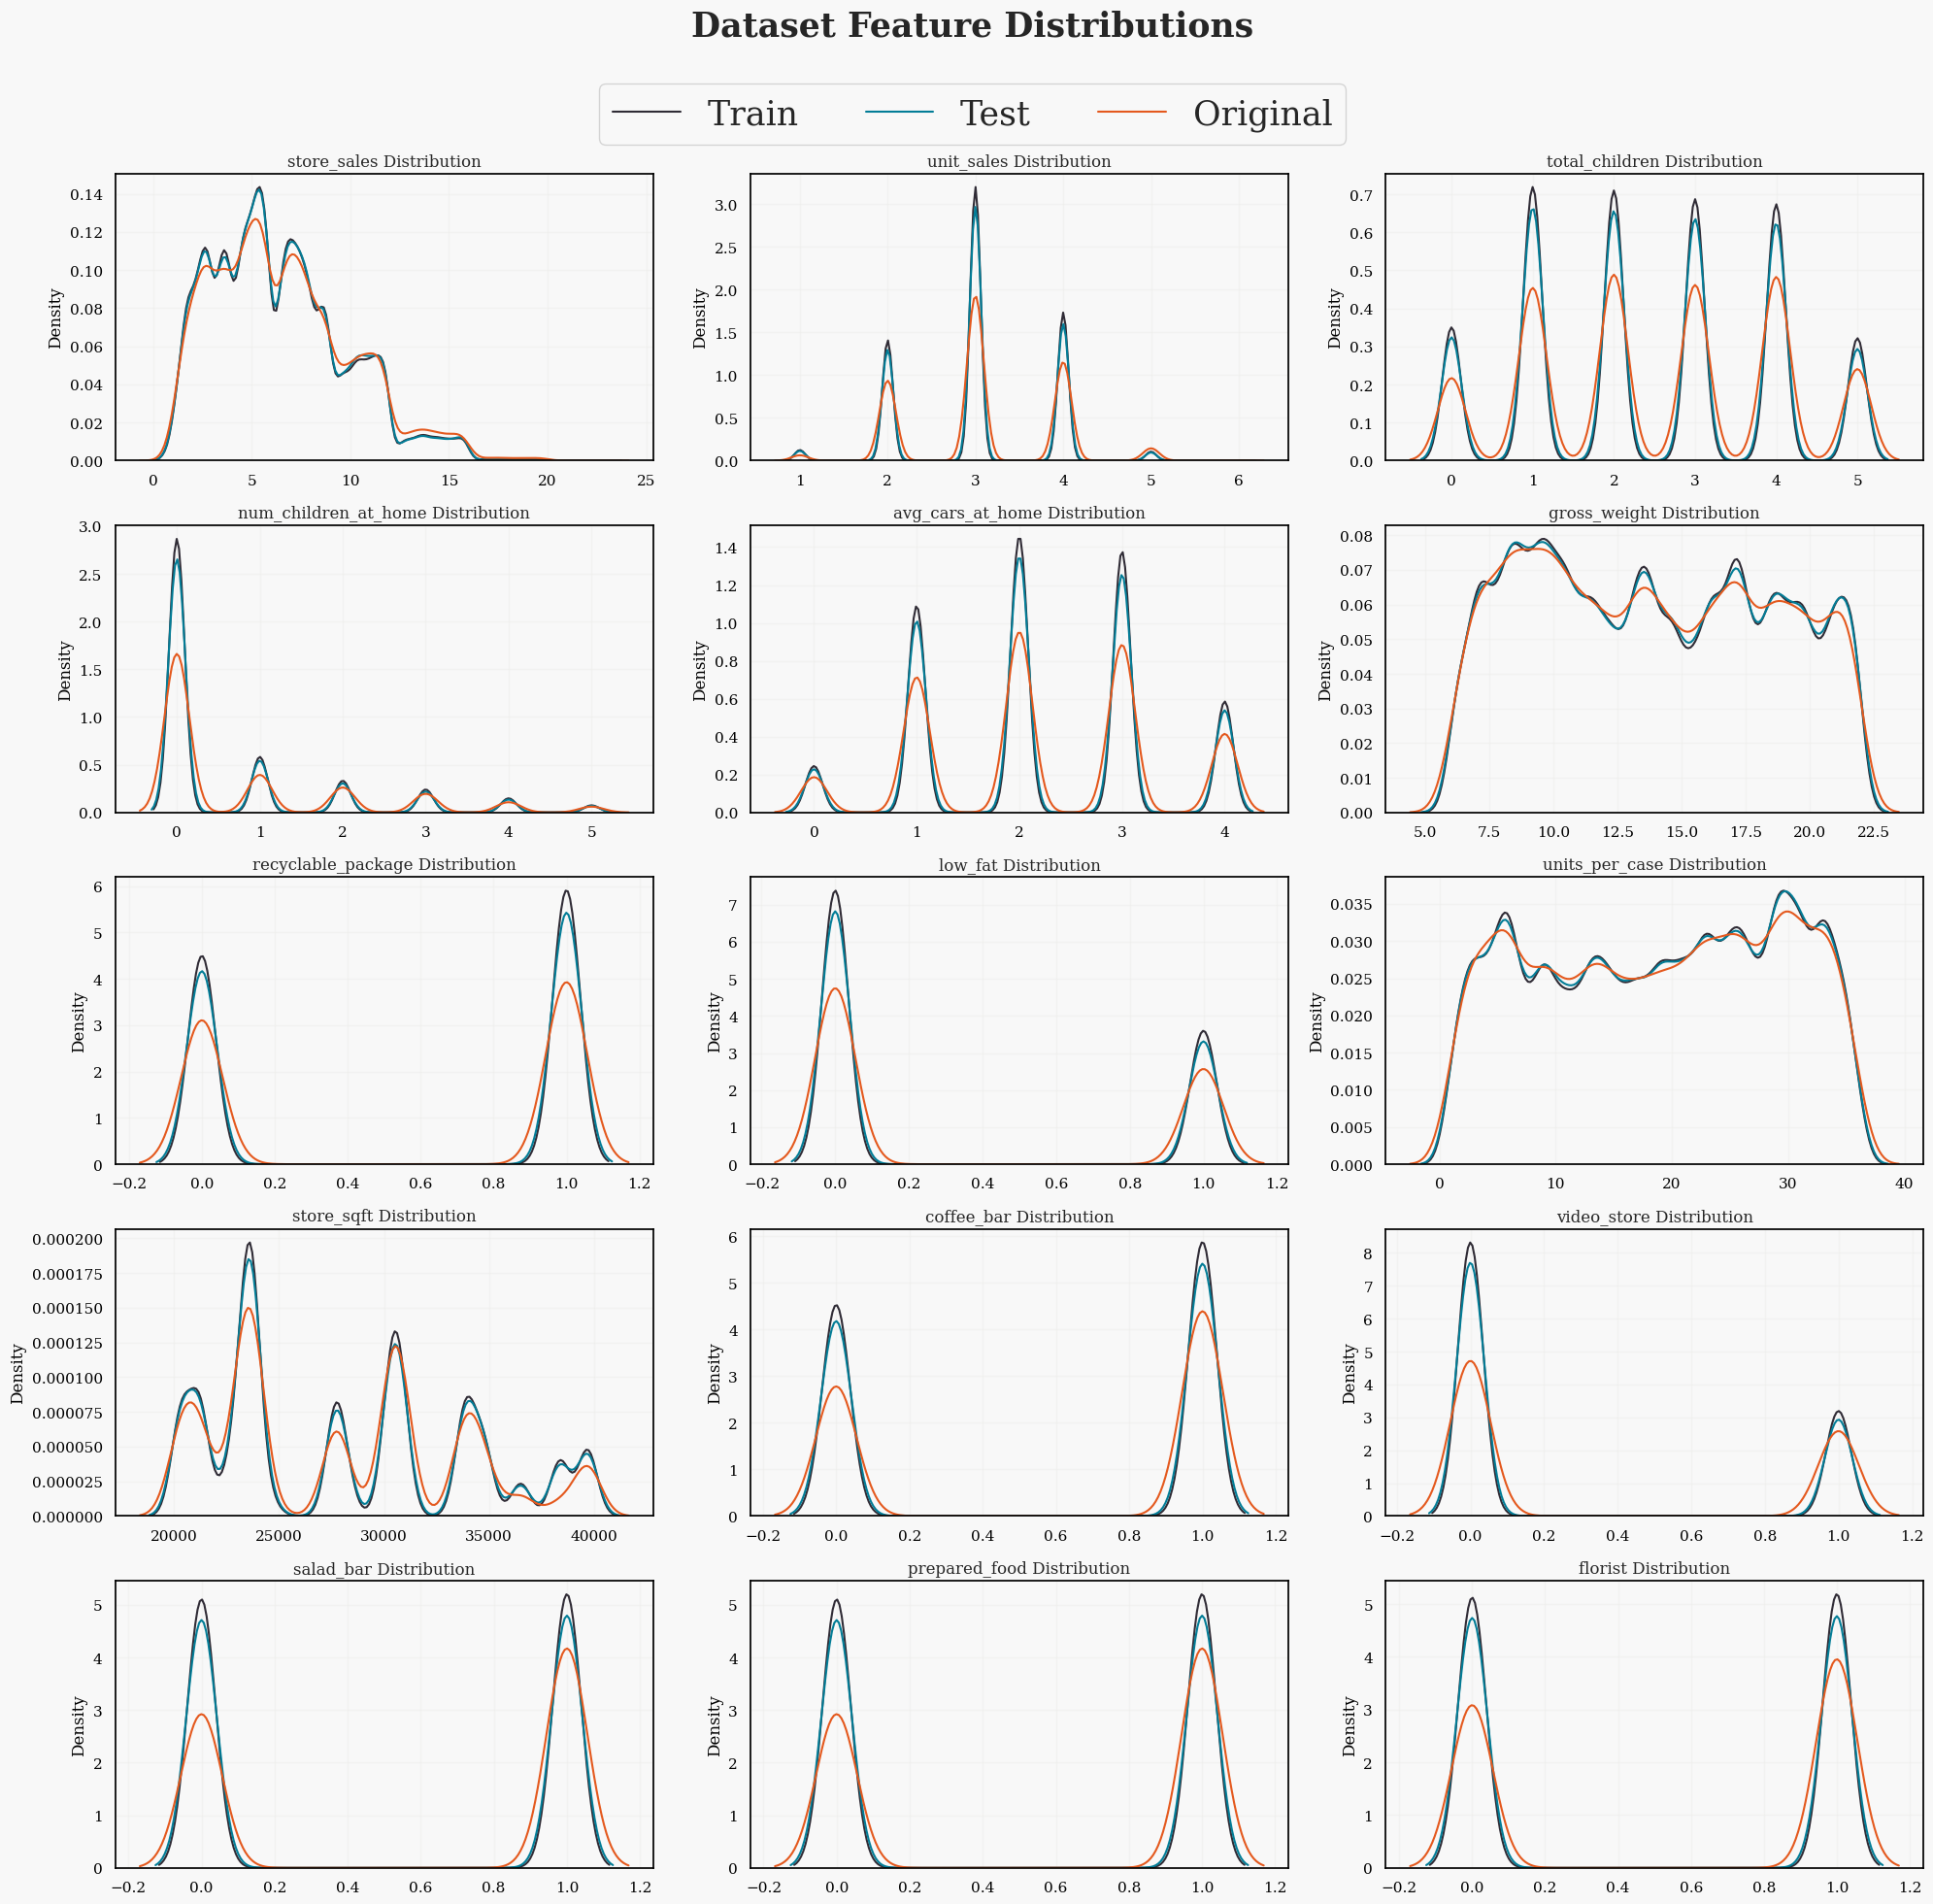

In [52]:
# kudos to @jcaliz
features = test.columns
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color=palette[0]
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color=palette[1]
    )
    
    sns.kdeplot(
        origin[column], label='Original',
        ax=ax[i], color=palette[2]
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=25, ncol=3)
plt.tight_layout()

### 观察到的情况：

特征分布与原始数据集接近，但不完全相同。
组织者告诉我们，在这次比赛中可以自由使用原始数据集，既可以探索差异，也可以看看在训练中加入原始数据集是否能提高模型性能。

### 需要记住的事情：

>合成数据集是一种通过使用各种技术生成模仿原始数据的新数据而创建的数据集。然而，合成数据集的特征有可能不紧跟原始数据集的分布（我们的例子）。这可能是由于各种因素造成的，如使用不同的采样技术，应用不同的数据转换，或引入原始数据集中不存在的新特征。当合成数据集的特征不紧跟原始数据集的分布时，会影响在原数据上训练的机器学习模型的性能，因为这些模型可能无法准确捕捉原始数据中的潜在模式和关系。因此，在使用这两个数据集之前，必须仔细评估它们的质量。

让我们看一下针对目标变量的训练数据集分类特征：

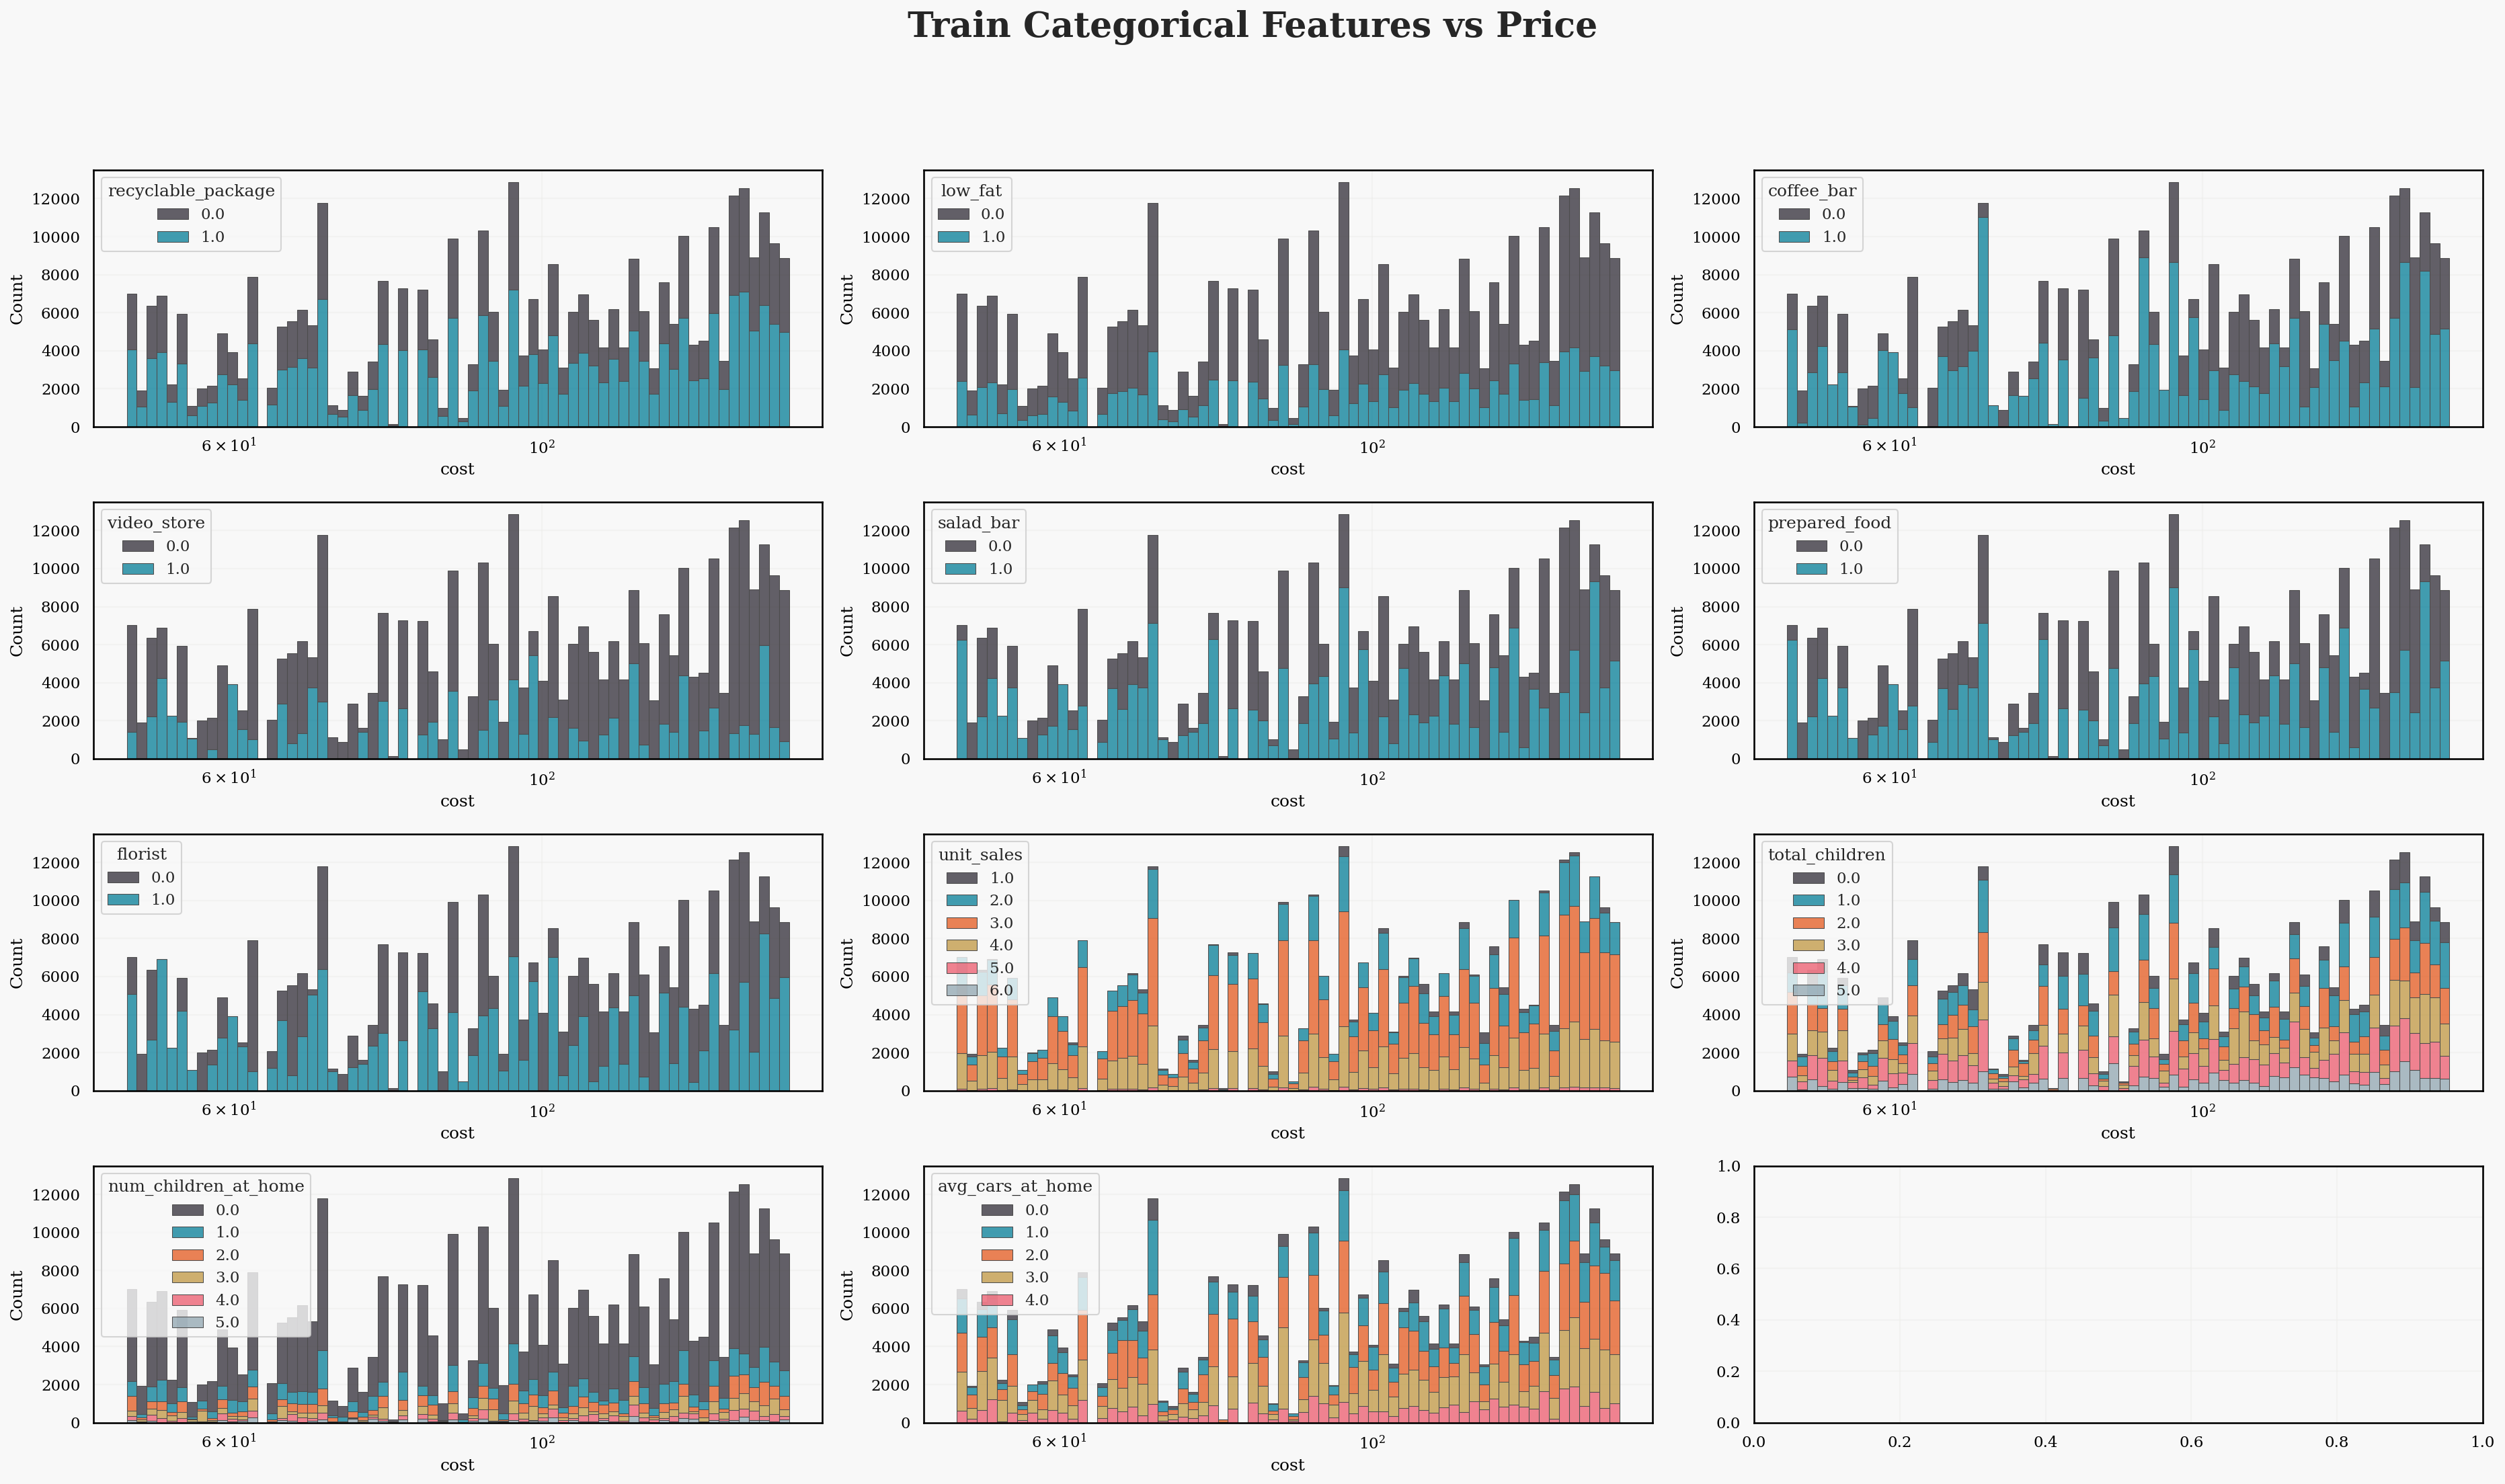

In [53]:
cat_features = ['recyclable_package', 'low_fat', 'coffee_bar',
                'video_store', 'salad_bar', 'prepared_food',
                'florist', 'unit_sales', 'total_children',
                'num_children_at_home', 'avg_cars_at_home']

fig, ax = plt.subplots(4, 3, figsize=(25, 15), dpi=150)
ax = ax.flatten()
for i, ft in enumerate(cat_features):
    sns.histplot(
        data=train,
        x="cost", hue=ft,
        multiple="stack",
        palette=palette,
        edgecolor=".3",
        linewidth=.5,
        log_scale=True,
        ax=ax[i],
    )
fig.suptitle(f'Train Categorical Features vs Price\n\n\n', ha='center',  fontweight='bold', fontsize=25)
plt.tight_layout()
plt.show()

In [54]:
def validate_salad_eq_prepared(df: pd.DataFrame, df_name: str) -> None:
    percent_eq = (df['salad_bar'] == df['prepared_food']).sum()/df.shape[0]*100
    abs_ne = (df['salad_bar'] == df['prepared_food']).sum() - df.shape[0]
    print(f'[INFO] {df_name} dataset "salad_bar" equals to '
          f'"prepared_food" in {percent_eq:.2f}% observations. Not equal: {abs_ne}')
          
validate_salad_eq_prepared(origin, 'Origin')
validate_salad_eq_prepared(train, 'Train ')
validate_salad_eq_prepared(test, 'Test  ')

[INFO] Origin dataset "salad_bar" equals to "prepared_food" in 100.00% observations. Not equal: 0
[INFO] Train  dataset "salad_bar" equals to "prepared_food" in 99.99% observations. Not equal: -29
[INFO] Test   dataset "salad_bar" equals to "prepared_food" in 99.99% observations. Not equal: -16


#### 注意：

可能会删除salad_bar或prepared_food列,看看效果如何,因为它们几乎相同。

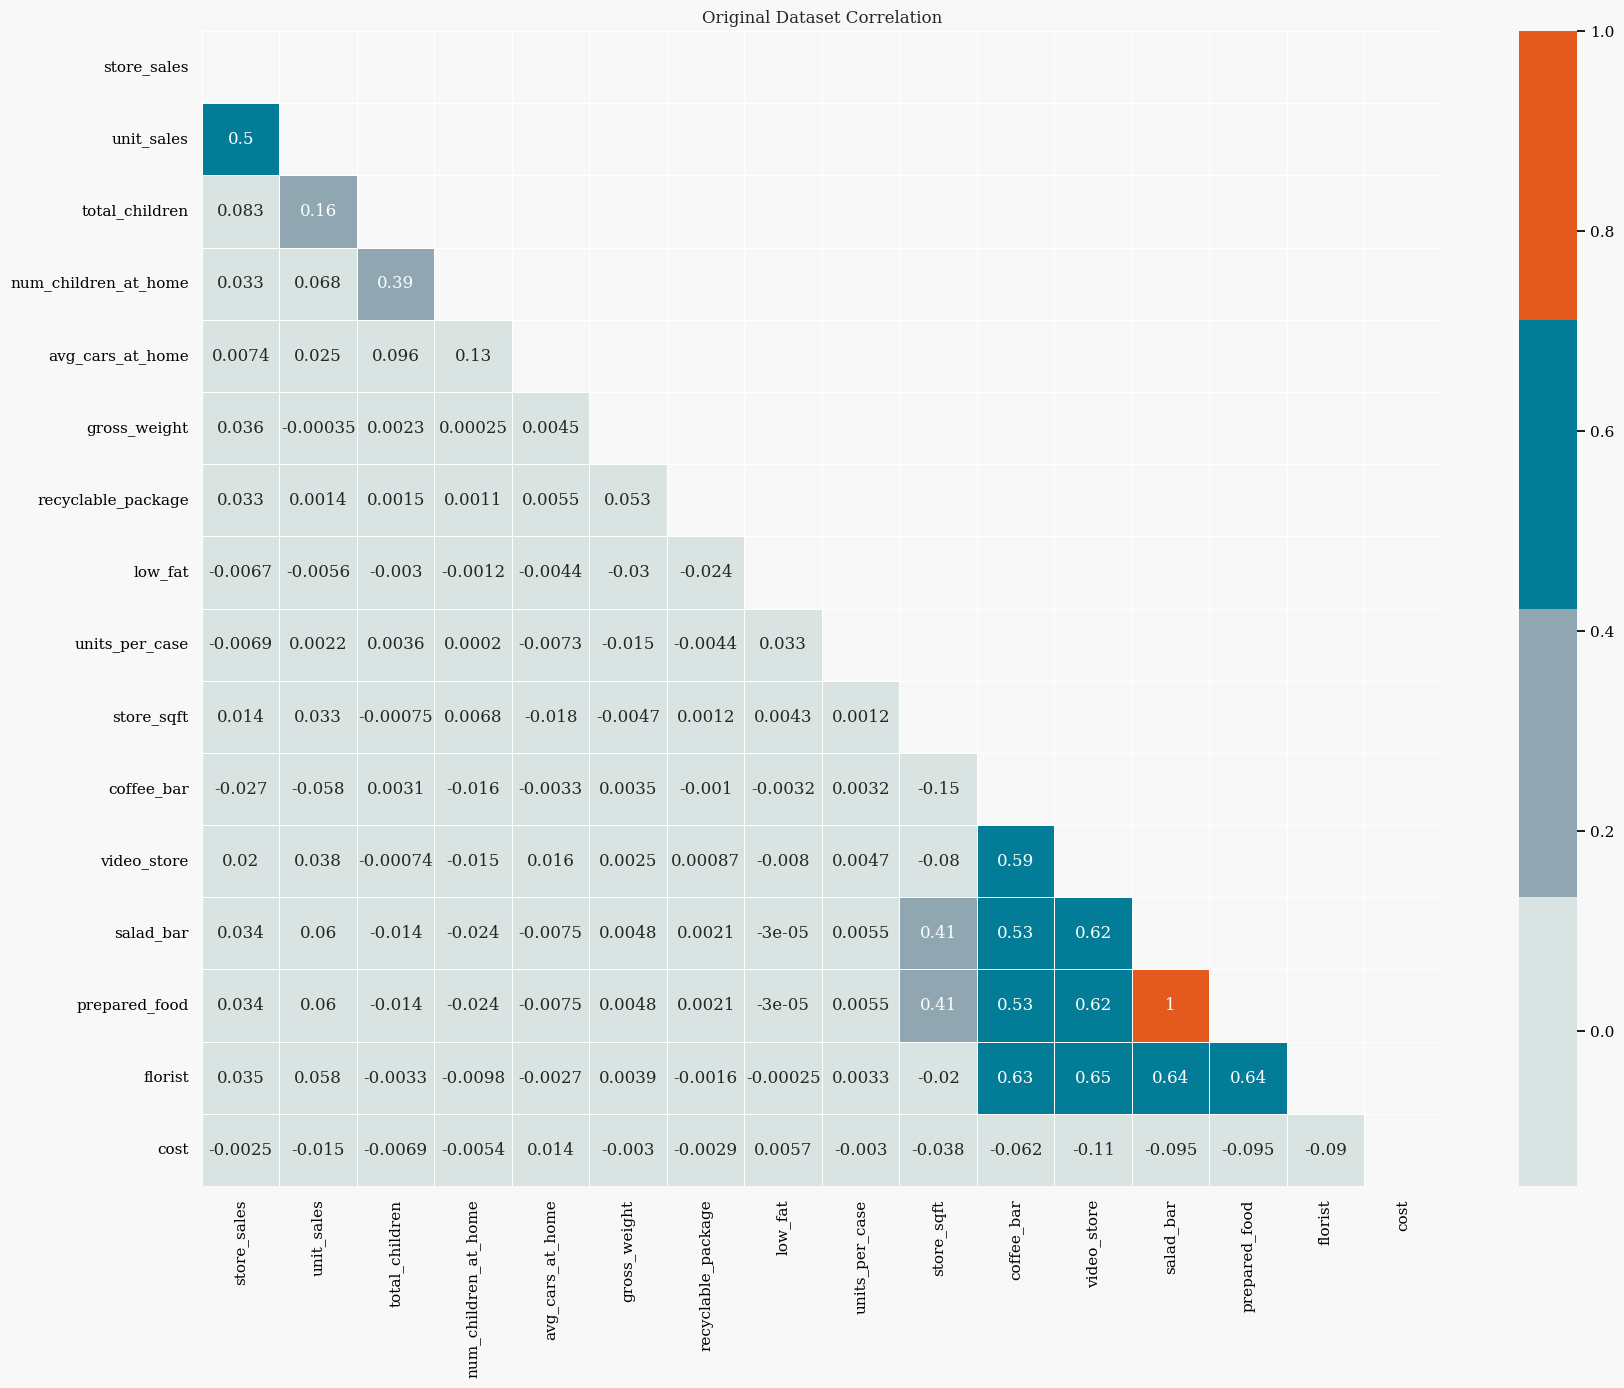

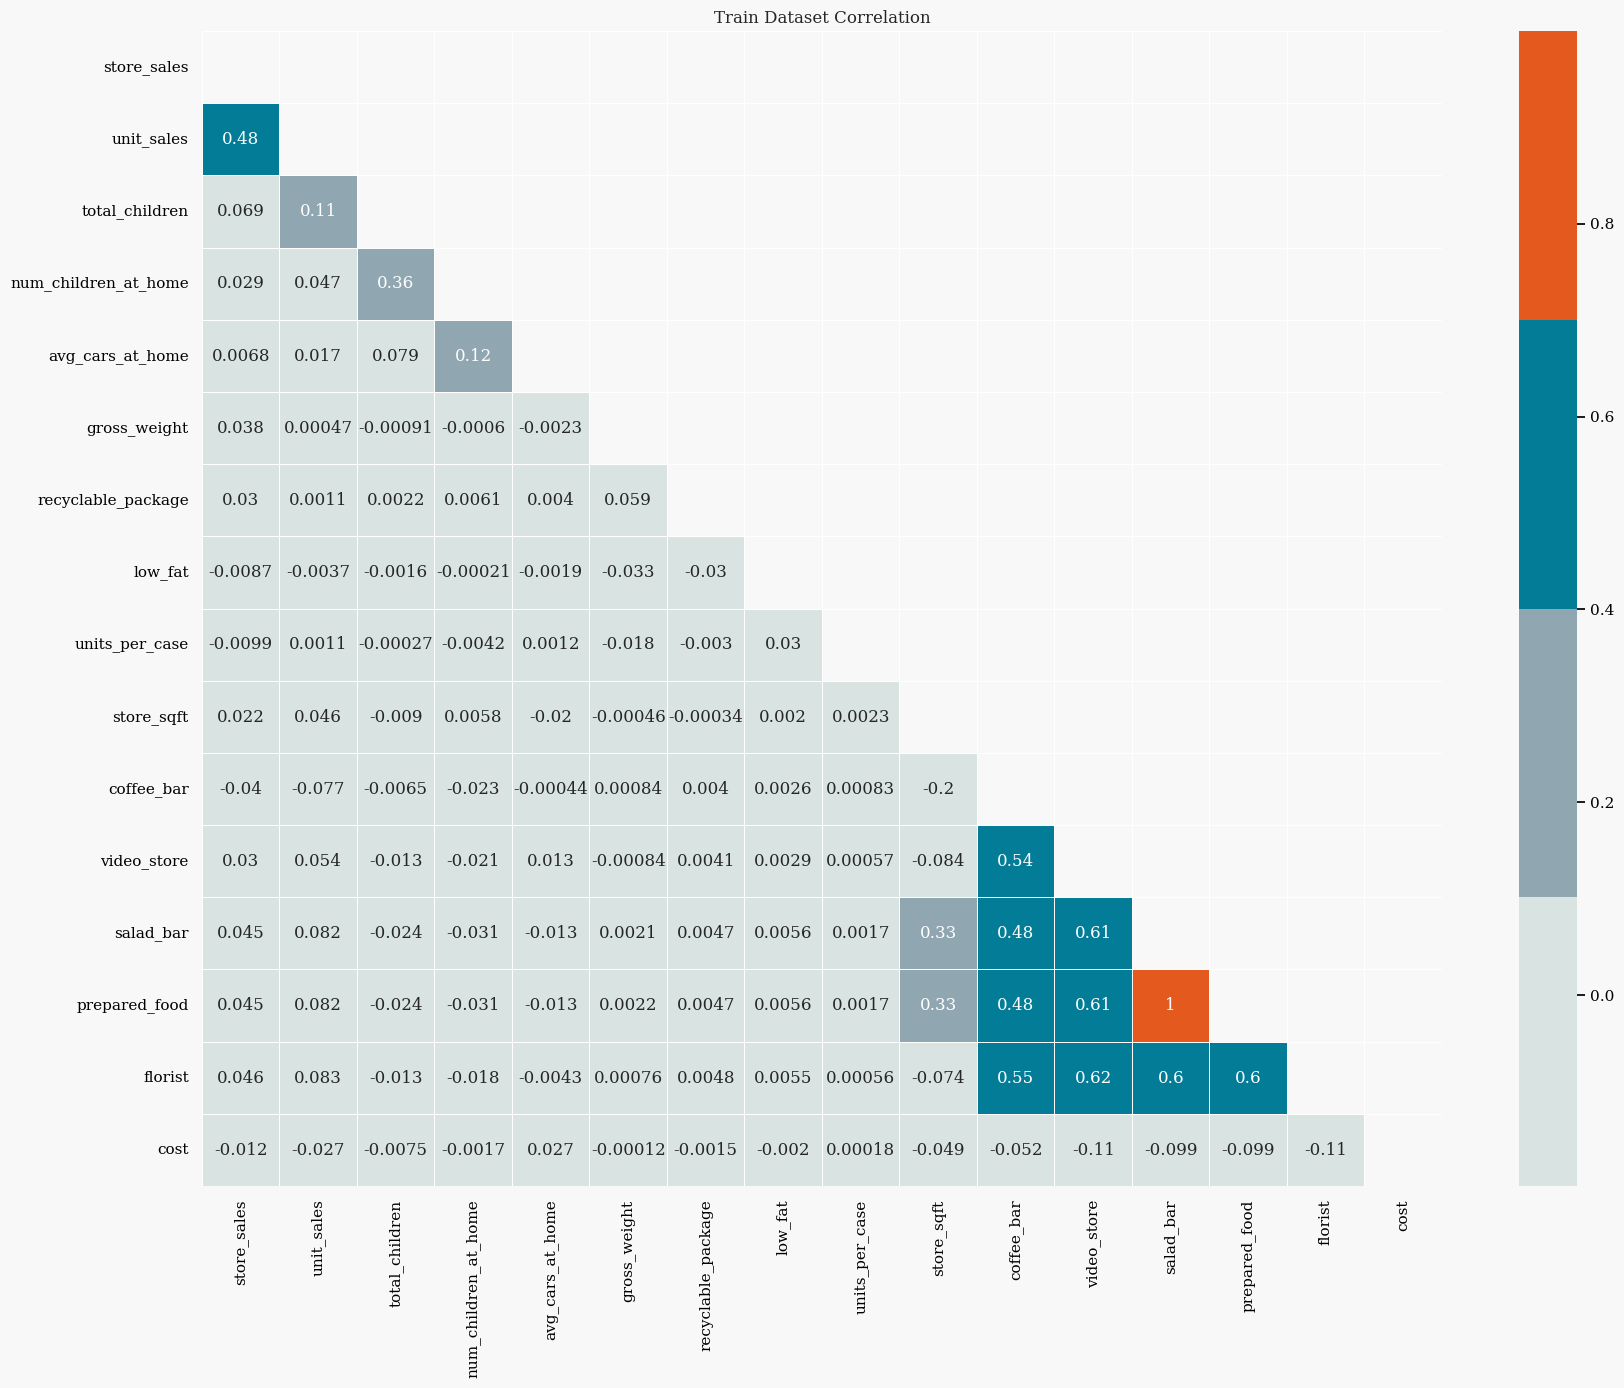

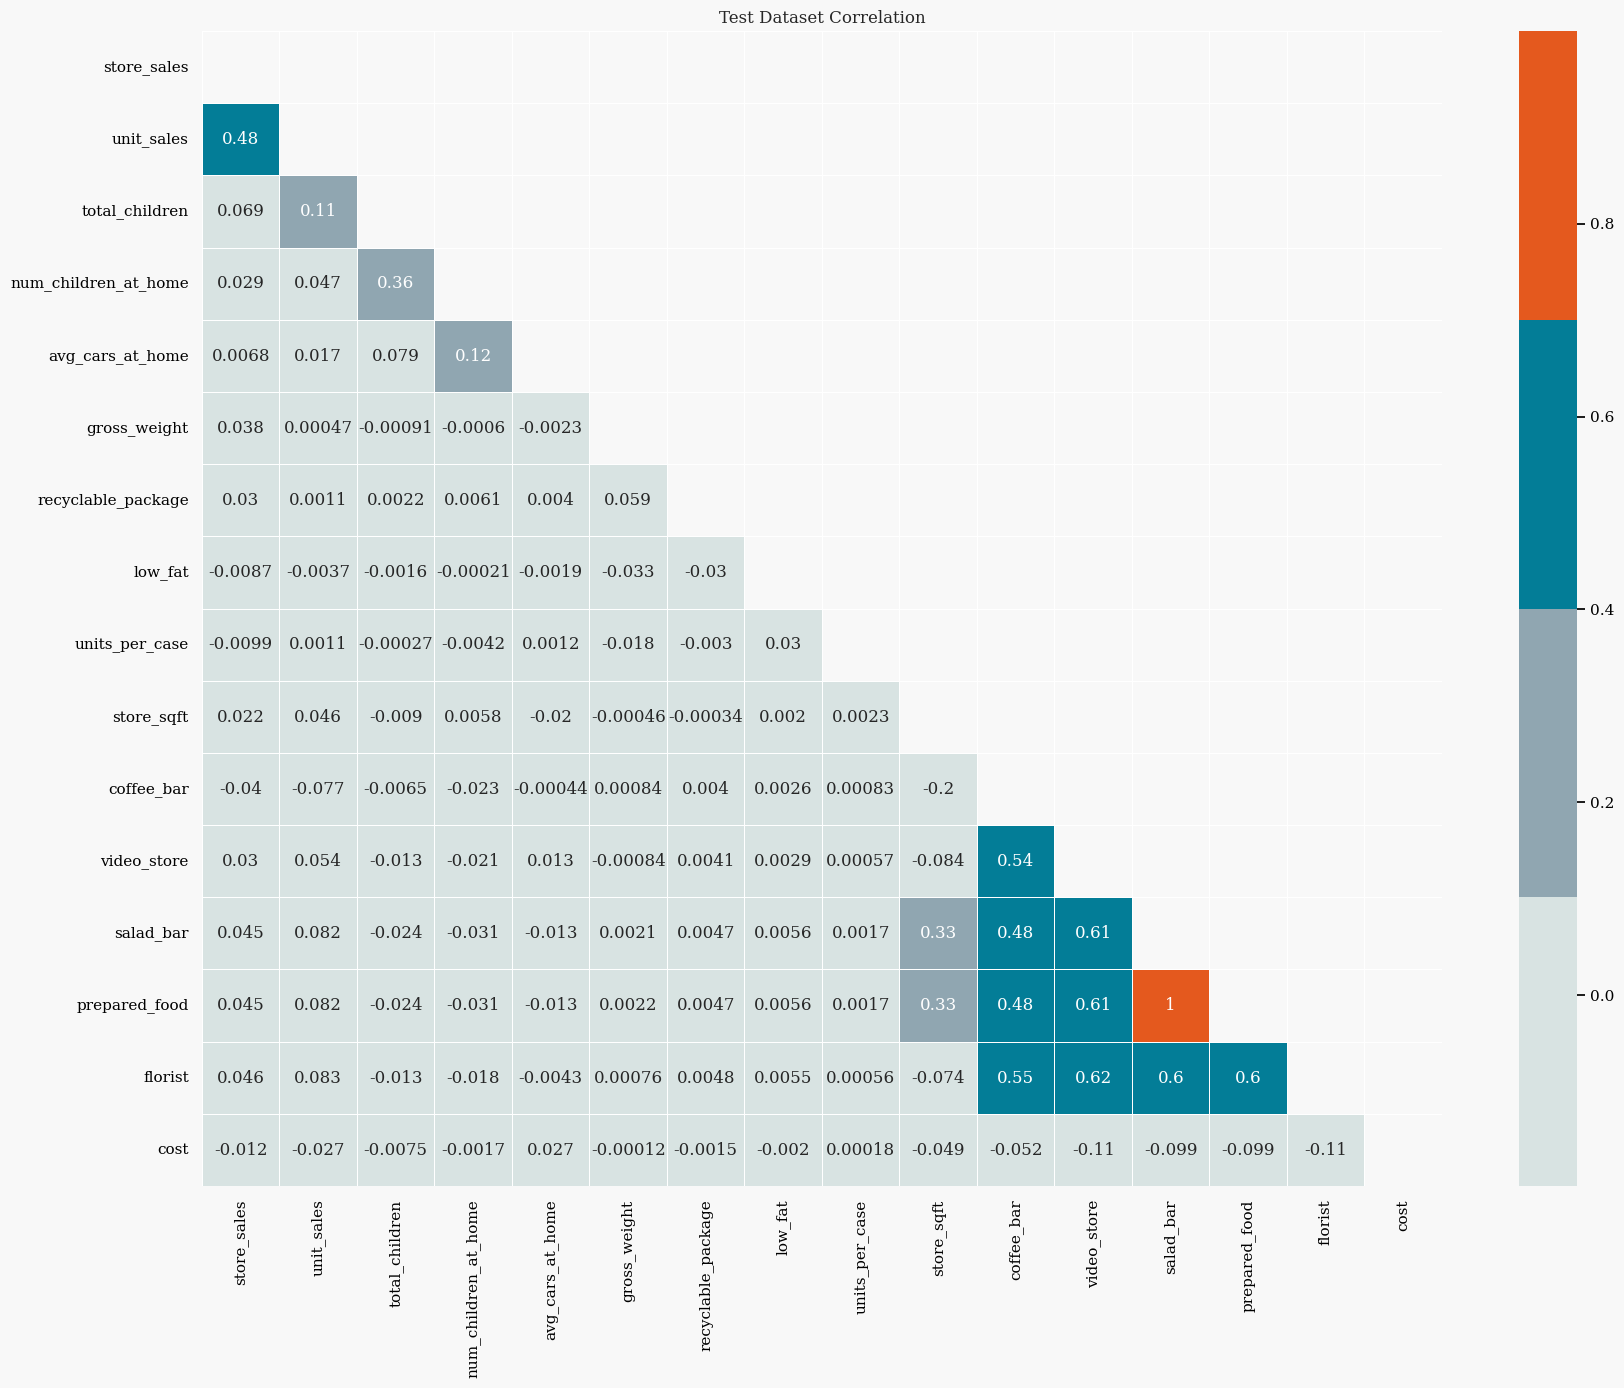

In [55]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 15))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap=palette[5:][::-2] + palette[1:3], annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(origin, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(train, 'Test Dataset Correlation')

追查重复和遗漏

In [56]:
from itertools import combinations

columns = train.drop(columns=['cost', 'salad_bar']).columns

def get_columns_combinations(columns, tr=None):
    """Returns all combinations of columns
        Args:
            columns: array of column names
            tr: (int) num of columns. If None, default all columns.
        
        Returns:
            all_combs: (list of lists) all possible column combinations.
    """
    n_comb = len(columns)
    if tr:
        n_comb = len(columns[:tr])
    all_combs = []
    for i in range(13, n_comb+1):
        all_combs += list(map(list, combinations(columns, r=i)))
    return all_combs

print(f'{red}[INFO] 伪-训练重复-数量, col:\n\n')
all_combs = get_columns_combinations(columns)
for cols in all_combs:
    s = train[cols].duplicated().sum()
    if s > 5:
        print(f'{red}{s}{blk}, {cols}')
        
print(f'{red}\n[INFO] 伪训练-测试重复-数量, col:\n\n')
all_combs = get_columns_combinations(columns)
for cols in all_combs:
    s = pd.concat([train, test])[cols].duplicated().sum()
    if s > 5:
        print(f'{red}{s}{blk}, {cols}')

[INFO] 伪-训练重复-数量, col:


83, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'prepared_food']
80, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'florist']
163, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'prepared_food', 'florist']
420, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'video_store', 'prepared_food', 'florist']
39522, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_ho

In [57]:
class MediaDataProcessor:
    def __init__(self,
                 train_data=None,
                 test_data=None,
                 combined: bool = False,
                 verbose: bool = False):
        self.origin_data = None
        self.train_data = train_data
        self.test_data = test_data
        self.combined = combined
        self.verbose = verbose

        if self.verbose:
            print(f'{blk}[INFO] Shapes before feature engineering:'
                  f'{blk}\n[+] train  -> {red}{self.train_data.shape}'
                  f'{blk}\n[+] test   -> {red}{self.test_data.shape}\n')
            
    @staticmethod
    def fe(df):
        df.unit_sales = df.unit_sales.clip(0, 5)
        df['children_ratio'] = df['total_children']/df['num_children_at_home']
        df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf], 10)
        return df

    def process_data(self):
        
        self.train_data = self.fe(self.train_data)
        self.test_data = self.fe(self.test_data)

        if self.combined:
            cols = self.train_data.columns
            self.origin_data = self.fe(self.origin_data)
            self.train_data = pd.concat([self.train_data, self.origin_data])
            self.train_data = self.train_data.drop_duplicates(subset=cols).reset_index(drop=True)

        if self.verbose:
            print(f'{blk}[INFO] Shapes after feature engineering:'
                  f'{blk}\n[+] train  -> {red}{self.train_data.shape}'
                  f'{blk}\n[+] test   -> {red}{self.test_data.shape}\n')

        return self.train_data, self.test_data
    
f_e = MediaDataProcessor(train, test, verbose=True)
train, test = f_e.process_data()

[INFO] Shapes before feature engineering:
[+] train  -> (360336, 16)
[+] test   -> (240224, 15)

[INFO] Shapes after feature engineering:
[+] train  -> (360336, 17)
[+] test   -> (240224, 16)



In [58]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred, squared=False)

In [62]:
# %%time
config = {'SEED': 42,
          'FOLDS': 15,
          'N_ESTIMATORS': 700}

# kudos to @shashwatraman
xgb_params = {'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'learning_rate': 0.05,
              'max_depth': 8,
              'early_stopping_rounds': 200,
              'tree_method': 'hist',
              'subsample': 1.0,
              'colsample_bytree': 1.0,
              'verbosity': 0,
              'random_state': 42}

cols_to_drop = ['cost', 'store_sales', 'gross_weight', 'unit_sales', 'low_fat',
                'recyclable_package', 'salad_bar','units_per_case', ]

X, y = train.drop(columns=cols_to_drop), train.cost
y = np.log(y)

cv = model_selection.KFold(n_splits=config['FOLDS'], shuffle=True, random_state=config['SEED'])
feature_importances_ = pd.DataFrame(index=X.columns)
metric = rmsle
eval_results_ = {}
models_ = []
oof = np.zeros(len(X))

for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):

    # Split the dataset according to the fold indexes.
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    # XGB .train() requires xgboost.DMatrix.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix
    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    # Training.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
    eval_results_[fold] = {}
    model = xgb.train(
        num_boost_round=config['N_ESTIMATORS'],
        params=xgb_params,
        dtrain=fit_set,
        evals=watchlist,
        evals_result=eval_results_[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )

    val_preds = model.predict(val_set)
    oof[val_idx] = val_preds

    val_score = metric(np.exp(y_val), np.exp(val_preds))
    best_iter = model.best_iteration
    print(f'Fold: {blu}{fold:>3}{res}| {metric.__name__}: {blu}{val_score:.5f}{res}'
          f' | Best iteration: {blu}{best_iter:>4}{res}')

    # Stores the feature importances
    feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='gain'))
    feature_importances_[f'split_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='weight'))

    # Stores the model
    models_.append(model)

mean_cv_score = metric(np.exp(y), np.exp(oof))
print(f'{"*" * 50}\n{red}Mean{res} {metric.__name__}: {red}{mean_cv_score:.5f}')

Fold:   1| rmsle: 0.29416 | Best iteration:  697
Fold:   2| rmsle: 0.29438 | Best iteration:  690
Fold:   3| rmsle: 0.29125 | Best iteration:  680
Fold:   4| rmsle: 0.29230 | Best iteration:  696
Fold:   5| rmsle: 0.29169 | Best iteration:  698
Fold:   6| rmsle: 0.29141 | Best iteration:  699
Fold:   7| rmsle: 0.29290 | Best iteration:  699
Fold:   8| rmsle: 0.29355 | Best iteration:  673
Fold:   9| rmsle: 0.29227 | Best iteration:  694
Fold:  10| rmsle: 0.29439 | Best iteration:  696
Fold:  11| rmsle: 0.29361 | Best iteration:  669
Fold:  12| rmsle: 0.29152 | Best iteration:  691
Fold:  13| rmsle: 0.29321 | Best iteration:  510
Fold:  14| rmsle: 0.29377 | Best iteration:  699
Fold:  15| rmsle: 0.29501 | Best iteration:  696
**************************************************
Mean rmsle: 0.29303


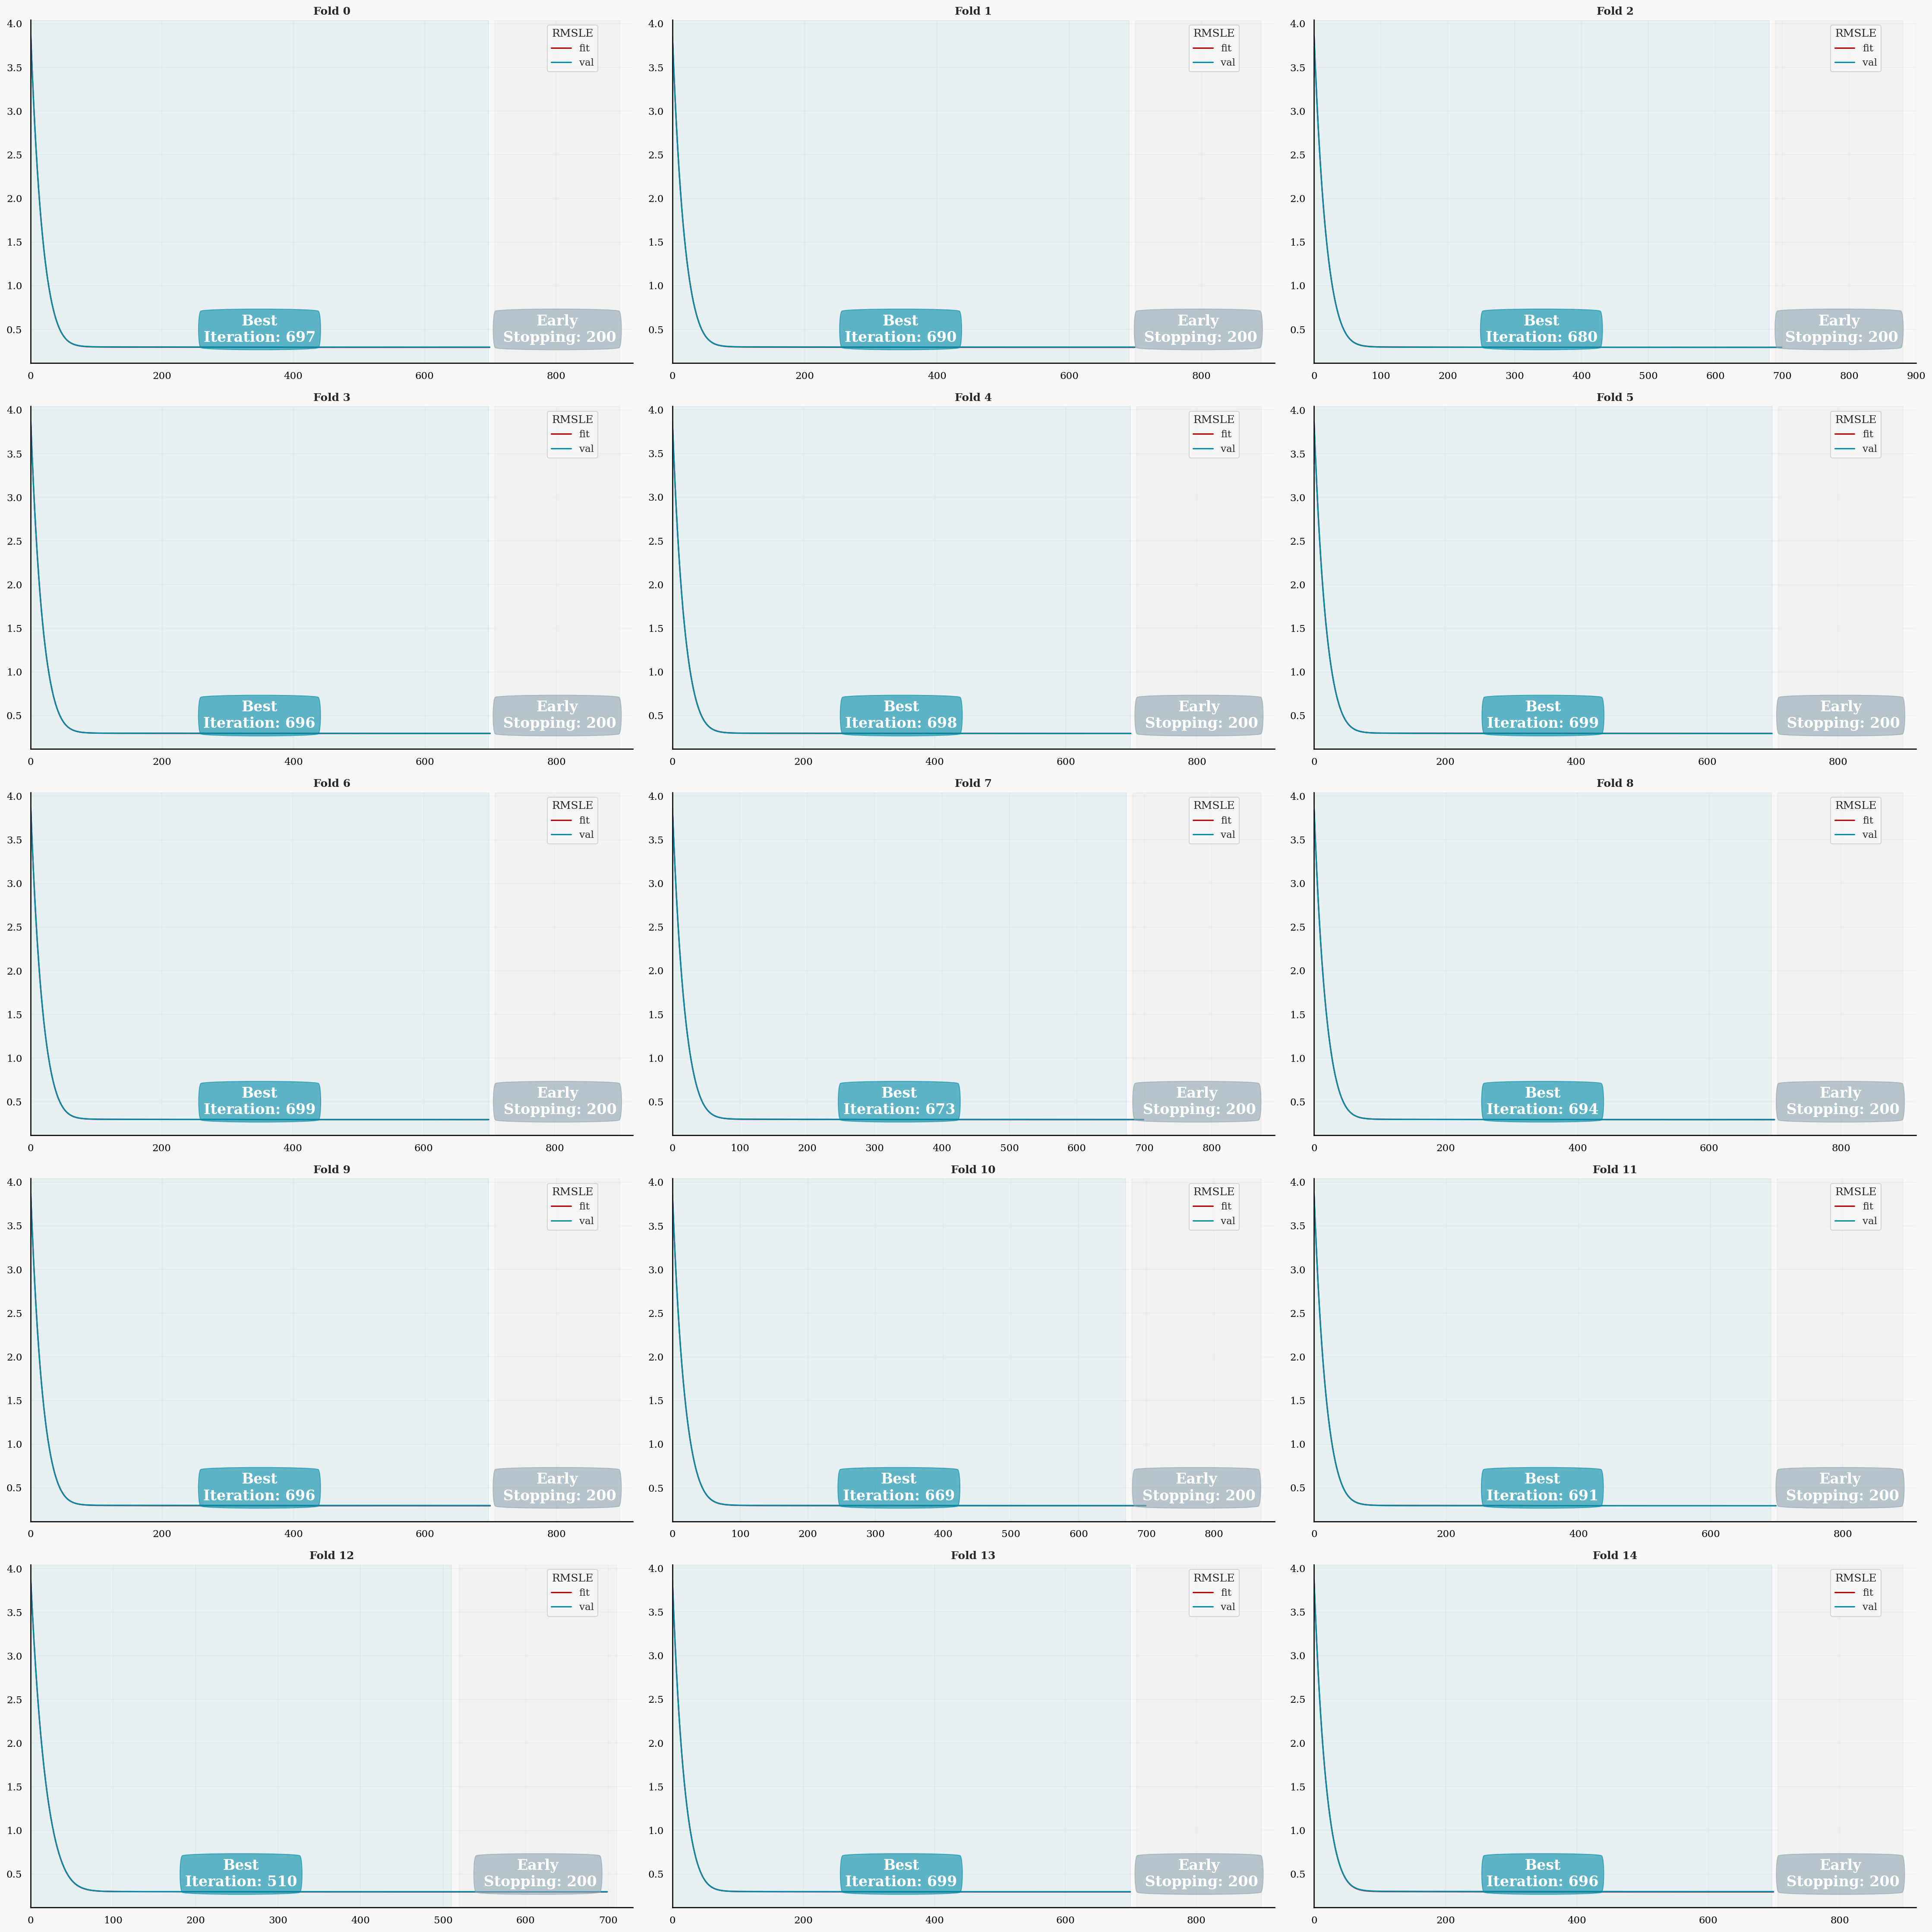

In [63]:
metric_score_folds = pd.DataFrame.from_dict(eval_results_).T
fit_rmsle = metric_score_folds.fit.apply(lambda x: x['rmse'])
val_rmsle = metric_score_folds.val.apply(lambda x: x['rmse'])

fig, axes = plt.subplots(math.ceil(config['FOLDS']/3), 3, figsize=(30, 30), dpi=150)
ax = axes.flatten()
for i, (f, v, m) in enumerate(zip(fit_rmsle, val_rmsle, models_)): 
    sns.lineplot(f, color='#B90000', ax=ax[i], label='fit')
    sns.lineplot(v, color='#048BA8', ax=ax[i], label='val')
    ax[i].legend()
    ax[i].spines['top'].set_visible(False);
    ax[i].spines['right'].set_visible(False)
    ax[i].set_title(f'Fold {i}', fontdict={'fontweight': 'bold'})
    
    color =  ['#048BA8', palette[-3]]
    best_iter = m.best_iteration
    span_range = [[0, best_iter], [best_iter + 10, best_iter + xgb_params['early_stopping_rounds']]]
    
    for idx, sub_title in enumerate([f'Best\nIteration: {best_iter}', f'Early\n Stopping: {xgb_params["early_stopping_rounds"]}']):
        ax[i].annotate(sub_title,
                    xy=(sum(span_range[idx])/2 , 0.5),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax[i].axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)
        
    ax[i].set_xlim(0, best_iter + 20 + xgb_params["early_stopping_rounds"])
    ax[i].legend(bbox_to_anchor=(0.95, 1), loc='upper right', title='RMSLE')

plt.tight_layout();

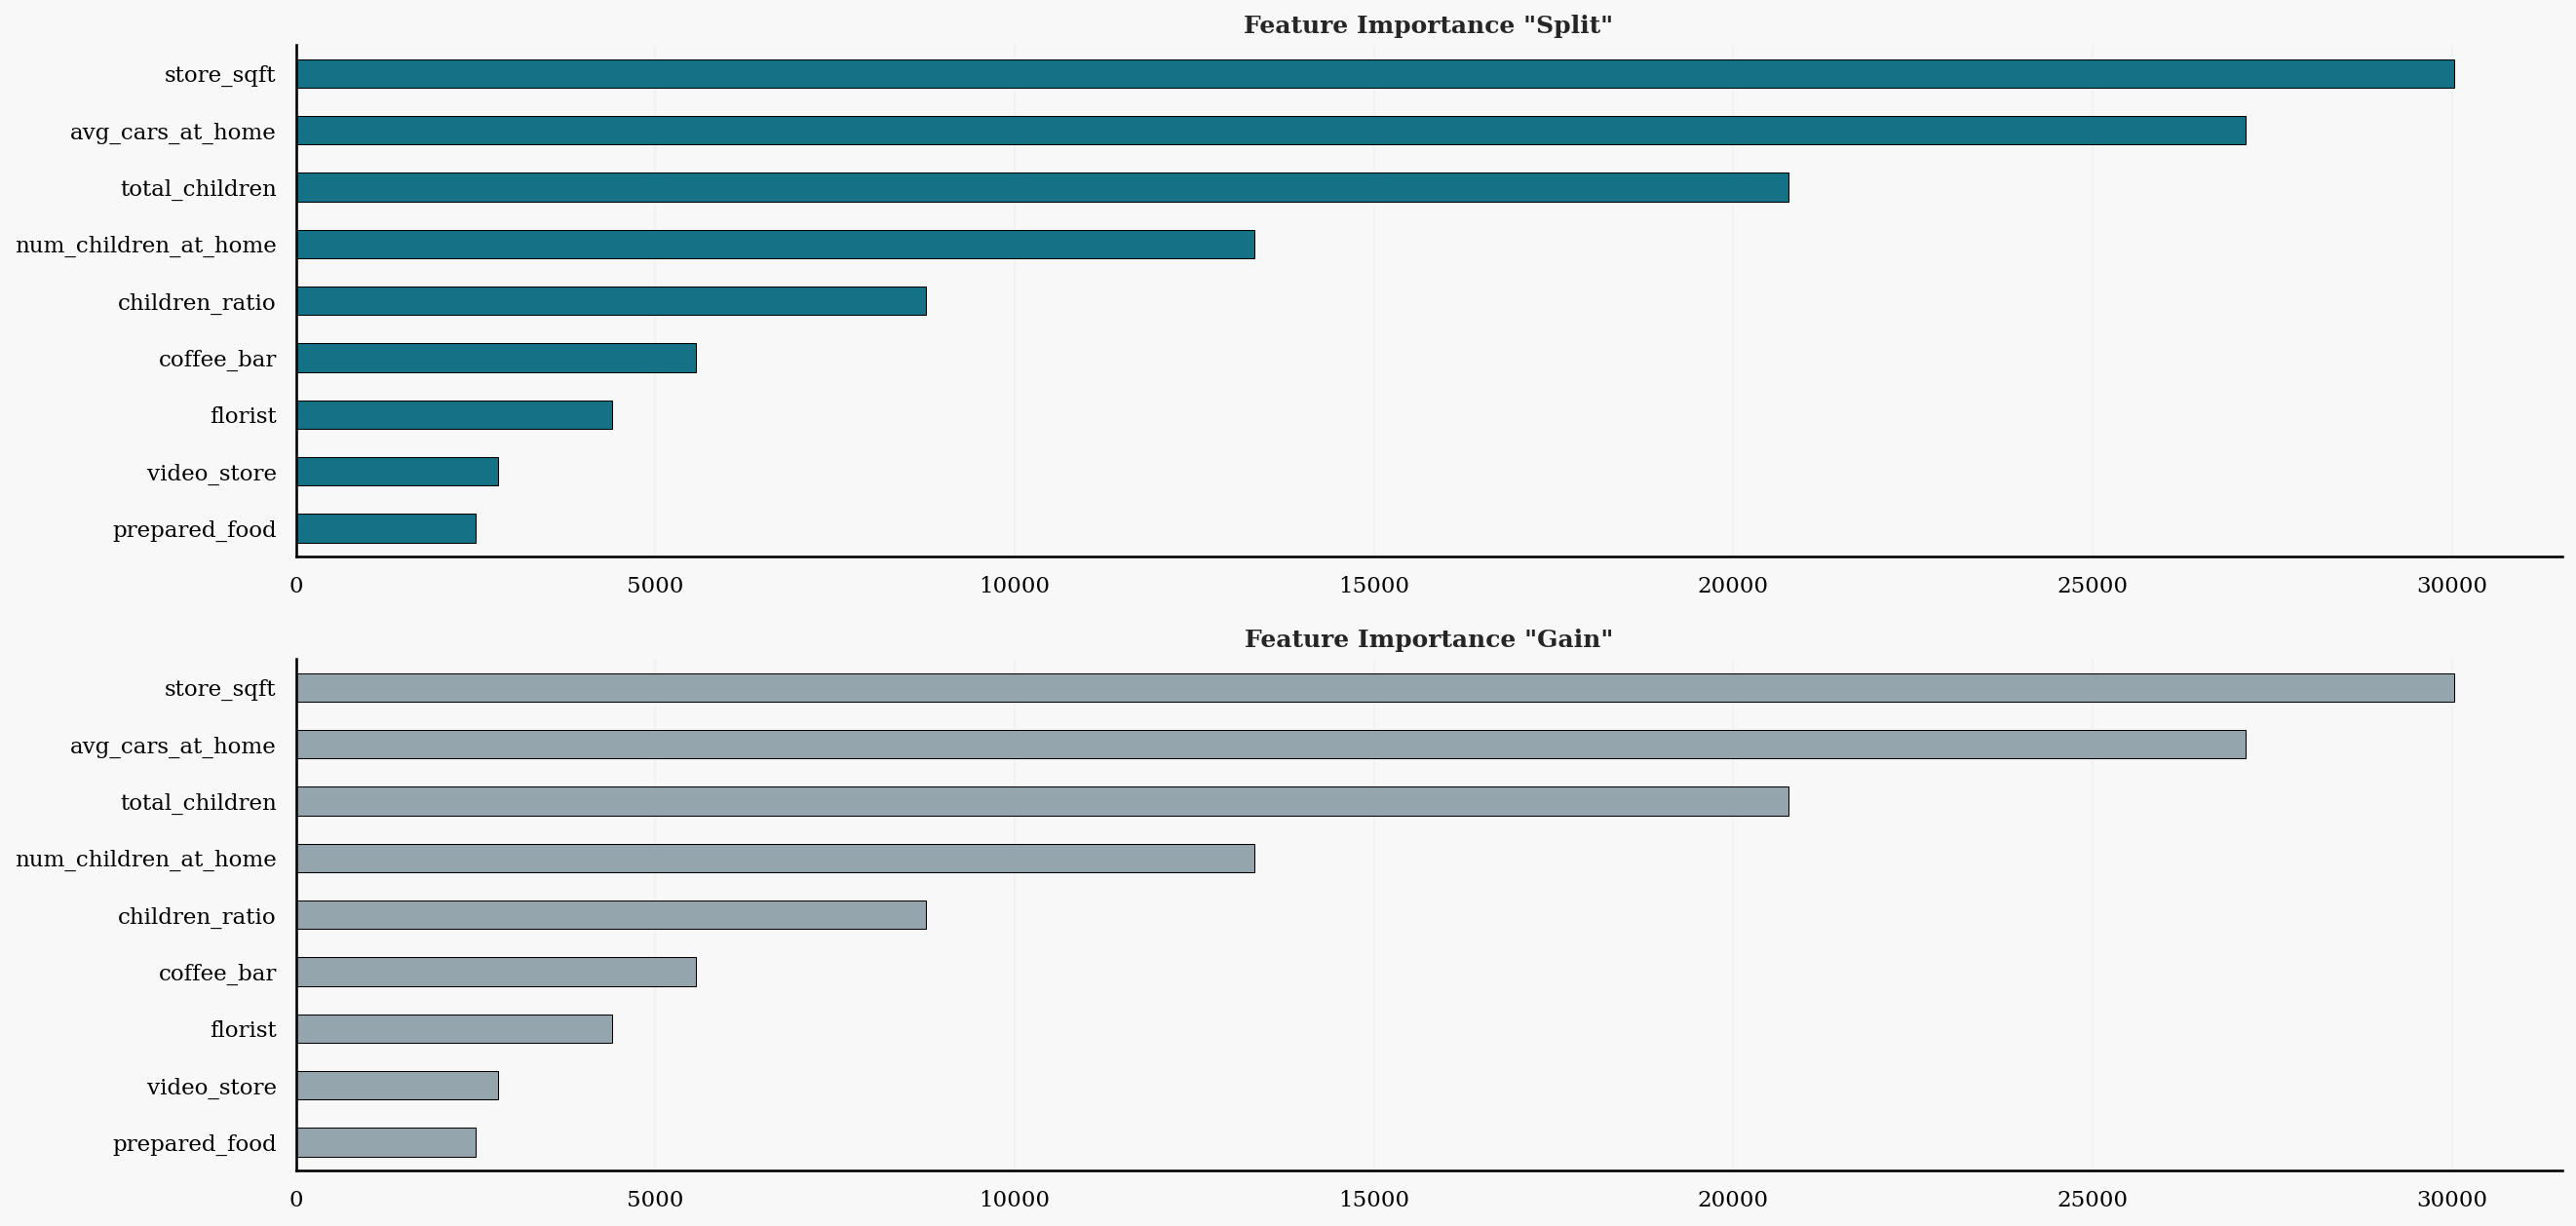

In [64]:
fi = feature_importances_
fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), dpi=150)
ax = ax.flatten()
# Split fi.
data_splt = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_splt.values, y=data_splt.index, 
            color=palette[1], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[0])
ax[0].set_title(f'Feature Importance "Split"', fontdict={'fontweight': 'bold'})
ax[0].set(xlabel=None)

for s in ['right', 'top']:
    ax[0].spines[s].set_visible(False)
ax[0]
# Gain fi.    
data_gain = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_gain.values, y=data_gain.index,
            color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[1])
ax[1].set_title(f'Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
ax[1].set(xlabel=None)

for s in ['right', 'top']:
    ax[1].spines[s].set_visible(False)

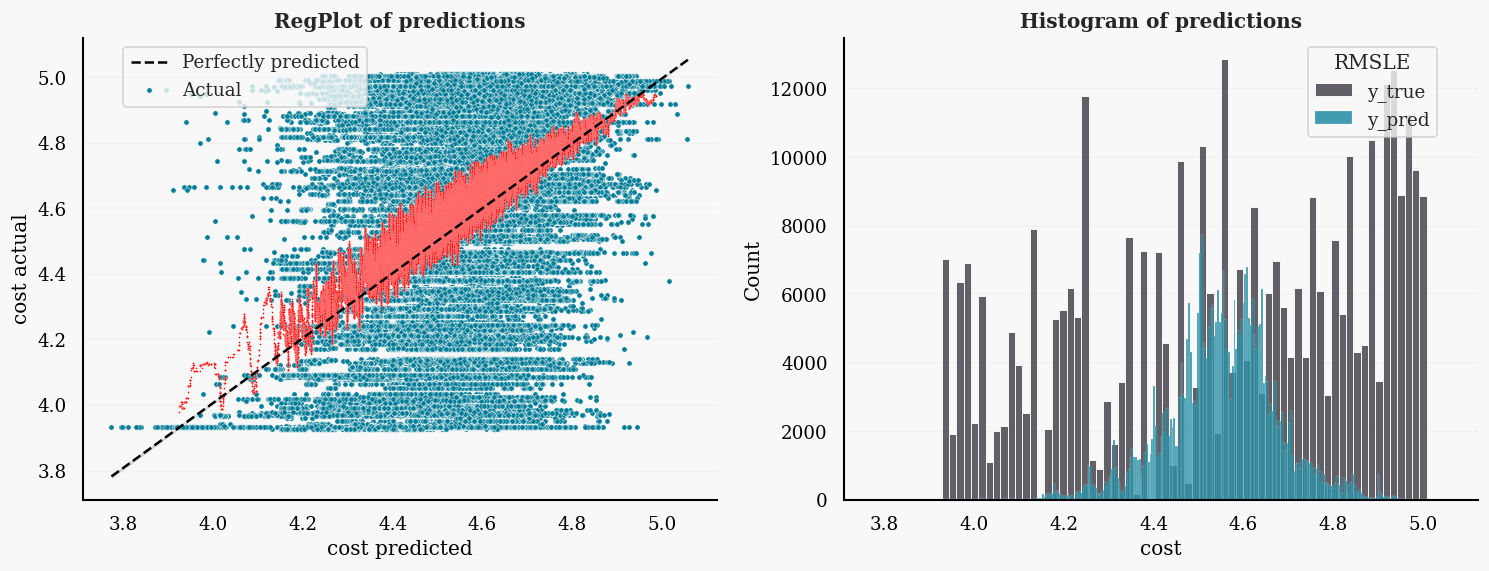

In [65]:
oof_df = pd.DataFrame(np.vstack([oof, y]).T, columns=['cost_pred', 'cost'])

sort_idxs = np.argsort(oof)
oof_sorted = oof[sort_idxs]
y_true_sorted = train['cost'].iloc[sort_idxs]
y_true_sorted = pd.Series(y_true_sorted.values, index=oof_sorted)
y_roll_mean = np.log(y_true_sorted.rolling(80, center=True).mean())

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
ax = ax.flatten()
sns.regplot(data=oof_df, x='cost_pred', y='cost', color=palette[1], scatter=False,
            line_kws={"color": "black", "linestyle": "--", "lw": 1.5}, ax=ax[0], label='Perfectly predicted')

sns.scatterplot(data=oof_df, x='cost_pred', y='cost', s=10, color=palette[1], ax=ax[0], label='Actual')
sns.scatterplot(x=y_roll_mean.index, y=y_roll_mean, color='red', s=1, ax=ax[0]);

ax[0].legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax[0].set(xlabel='cost predicted', ylabel='cost actual')

sns.histplot(oof_df.cost, color=palette[0], label='y_true', ax=ax[1])
sns.histplot(oof_df.cost_pred, color=palette[1], label='y_pred', ax=ax[1])
ax[1].legend(bbox_to_anchor=(0.95, 1), loc='upper right', title='RMSLE')
for i, _ in enumerate(ax):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].xaxis.grid(False)
    ax[i].yaxis.grid(True)
    
ax[0].set_title(f'RegPlot of predictions', fontdict={'fontweight': 'bold'})
ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'});

In [66]:
r2 = metrics.r2_score(oof_df.cost, oof_df.cost_pred)
print(f'{blk}R_squared: {red}{r2:.3f}{res}')

R_squared: 0.144


In [67]:
def predict(X):
    y = np.zeros(len(X))
    for model in tqdm(models_):
        y += np.exp(model.predict(xgb.DMatrix(X)))
    return y / len(models_)

predictions = predict(test.drop(columns=cols_to_drop[1:]))
sub = pd.read_csv(PATH_SUB)
sub.cost = predictions
sub.to_csv('submission.csv', index=False)
sub.head(3)

  0%|          | 0/15 [00:00<?, ?it/s]

,id,cost
0,360336,90.472930
1,360337,93.715361
2,360338,94.044600
